<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


## **Procesamiento de lenguaje natural**
# **Desafio 4: Modelo de lenguaje - QA BOT**

Se buscará construir un bot de preguntas y respuestas adaptando el ejemplo trabajado en clase del modelo traductor seq-to-seq basado en LSTMs.

Utilizaremos el dataset de preguntas y respuestas de **SQAC (Spanish Question-Answering Corpus)**


### **0. Datos e imports**

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [1]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
cuda = torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
!pip3 install torchinfo
from torchinfo import summary

In [4]:
import os
import platform

if os.access('torch_helpers.py', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl !wget https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py > torch_helpers.py
    else:
        !wget torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py

#### > Descarga de datos

Se utilizaran datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).

In [5]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [6]:
import os
import gdown
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [7]:
import json

text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f) # la variable data será un diccionario

In [8]:
# Observar los campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [9]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)

    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        # vamos separando el texto en "preguntas" (chat_in)
        # y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out

        # output sentence (decoder_output) tiene
        output_sentence = output + " "
        # output sentence input (decoder_input) tiene
        output_sentence_input = " " + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 6033


In [10]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  ', ' not bad and you ')

### 2 - Preprocesamiento

In [11]:
# Definir el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 8000

In [12]:
from torch_helpers import Tokenizer

input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)

input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

Palabras en el vocabulario: 1799
Sentencia de entrada más larga: 9


In [13]:
# A los filtros de símbolos del Tokenizer agregamos el "¿",
# sacamos los "<>" para que no afectar nuestros tokens
special_tokens = ["<pad>", "<unk>", "<sos>", "<eos>"]

# Los agregás manualmente antes de entrenar el tokenizer
output_tokenizer = Tokenizer(
    num_words=MAX_VOCAB_SIZE,
    filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n'
)

output_tokenizer.fit_on_texts(special_tokens + output_sentences)

output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
idx2word_outputs = {i: w for w, i in word2idx_outputs.items()}

print("Palabras en el vocabulario:", len(word2idx_outputs))

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE) # Se suma 1 por el primer <sos>
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

Palabras en el vocabulario: 1808
Sentencia de salida más larga: 9


In [14]:
PAD_TOKEN = output_tokenizer.word_index["<pad>"]
UNK_TOKEN = output_tokenizer.word_index["<unk>"]
SOS_TOKEN = output_tokenizer.word_index["<sos>"]
EOS_TOKEN = output_tokenizer.word_index["<eos>"]

In [15]:
# Por una cuestion de que no explote la RAM se limitará el tamaño de las sentencias de entrada
# a la mitad:
max_input_len = 18
max_out_len = 18

In [16]:
print(f"Vocab real: {len(word2idx_outputs)}")
print(f"MAX_VOCAB_SIZE: {MAX_VOCAB_SIZE}")
print(f"Embeddings realmente usados: {len(output_tokenizer.word_index)}")


Vocab real: 1808
MAX_VOCAB_SIZE: 8000
Embeddings realmente usados: 1808


> A la hora de realiza padding es importante teneer en cuenta que **en el encoder los ceros se agregan al comienzo** y **en el decoder al final**.

> Esto es porque la salida del encoder está basado en las últimas palabras de la sentencia (son las más importantes), mientras que en el decoder está basado en el comienzo de la secuencia de salida ya que es la realimentación del sistema y termina con fin de sentencia.

In [49]:
PAD_TOKEN

1800

In [50]:
import torch

def pad_sequences_torch(sequences, maxlen, padding='pre', padding_value=PAD_TOKEN):
    """
    Versión robusta: ignora secuencias vacías y evita RuntimeError.

    Args:
        sequences (list[list[int]]): lista de secuencias (ej. token ids)
        maxlen (int): longitud máxima final de cada secuencia
        padding ('pre' or 'post'): dónde agregar el padding
        padding_value (int): valor de padding (por defecto 0)

    Returns:
        torch.Tensor: tensor de tamaño (num_seqs, maxlen)
    """
    n = len(sequences)
    padded = torch.full((n, maxlen), padding_value, dtype=torch.long)

    for i, seq in enumerate(sequences):
        # ⚠️ si la secuencia está vacía, saltar
        if len(seq) == 0:
            continue

        seq = torch.tensor(seq[:maxlen], dtype=torch.long)
        seq_len = len(seq)

        if padding == 'pre':
            padded[i, -seq_len:] = seq
        else:  # 'post'
            padded[i, :seq_len] = seq

    return padded


In [52]:
encoder_input_sequences = pad_sequences_torch(input_integer_seq, maxlen=max_input_len, padding='pre')
decoder_input_sequences = pad_sequences_torch(output_integer_seq, maxlen=max_out_len, padding='post')

print("Encoder shape:", encoder_input_sequences.shape)
print("Decoder shape:", decoder_input_sequences.shape)
print("Encoder example:\n", encoder_input_sequences)

Encoder shape: torch.Size([6033, 18])
Decoder shape: torch.Size([6033, 18])
Encoder example:
 tensor([[1800, 1800, 1800,  ..., 1800, 1800,   19],
        [1800, 1800, 1800,  ...,   10,    7,    2],
        [1800, 1800, 1800,  ..., 1800, 1800,   11],
        ...,
        [1800, 1800, 1800,  ..., 1800, 1800,   19],
        [1800, 1800, 1800,  ...,    3,    8,   13],
        [1800, 1800, 1800,  ...,    2,  596,    3]])


In [53]:
decoder_output_sequences = pad_sequences_torch(output_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_output_sequences shape:", decoder_output_sequences.shape)


decoder_output_sequences shape: torch.Size([6033, 18])


> La última capa del modelo (softmax) necesita que los valores de salida
del decoder (decoder_sequences) estén en formato oneHotEncoder.

> Se utiliza "decoder_output_sequences" con la misma estrategia que se transformó la entrada del decoder.

In [54]:
class QADataset(Dataset):
    def __init__(self, encoder_input, decoder_input, decoder_output):
        self.encoder_inputs = encoder_input.long()
        self.decoder_inputs = decoder_input.long()
        self.decoder_outputs = decoder_output.long()  # sin one-hot para CrossEntropyLoss

        self.len = len(self.encoder_inputs)

    def __getitem__(self, idx):
        return (
            self.encoder_inputs[idx],
            self.decoder_inputs[idx],
            self.decoder_outputs[idx]
        )

    def __len__(self):
        return self.len


data_set = QADataset(encoder_input_sequences, decoder_input_sequences, decoder_output_sequences)

encoder_input_size = data_set.encoder_inputs.shape[1]
print("encoder_input_size:", encoder_input_size)

decoder_input_size = data_set.decoder_inputs.shape[1]
print("decoder_input_size:", decoder_input_size)

output_dim = data_set.decoder_outputs.shape
print("Output dim", output_dim)

encoder_input_size: 18
decoder_input_size: 18
Output dim torch.Size([6033, 18])


In [55]:
torch.manual_seed(42)
valid_set_size = int(data_set.len * 0.2)
train_set_size = data_set.len - valid_set_size

train_set = torch.utils.data.Subset(data_set, range(train_set_size))
valid_set = torch.utils.data.Subset(data_set, range(train_set_size, data_set.len))

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)

Tamaño del conjunto de entrenamiento: 4827
Tamaño del conjunto de validacion: 1206


In [56]:
input_sentences[:10]

['hello ',
 'hi how are you ',
 'hi ',
 'hi ',
 'hi ',
 'where are you working ',
 'bro ',
 'where are you from ',
 'i am from russia and you ',
 'i hate them most of the time ']

In [57]:
output_sentences[:10]

['hi how are you  ',
 'not bad and you  ',
 'hello  ',
 'hello  ',
 'hello how are you today  ',
 'bro  ',
 'where are you from  ',
 'i am from russia and you  ',
 'i am from the united states  ',
 'you are racist  ']

### **3 - Preparar los embeddings**

In [58]:
import os
import gdown
if os.access('gloveembedding.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1wlDBOrxPq2-3htQ6ryVo7K1XnzLcfh4r&export=download'
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings gloveembedding.pkl ya están descargados")

Los embeddings gloveembedding.pkl ya están descargados


In [78]:
import os
import gdown

if not os.path.exists("cc.en.300.vec"):
    print("Descargando embeddings FastText (puede tardar bastante, ~1.4GB)...")
    url = "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz"
    output = "cc.en.300.vec.gz"
    gdown.download(url, output, quiet=False)
    os.system("gunzip cc.en.300.vec.gz")
else:
    print("El archivo cc.en.300.vec ya está descargado.")


Descargando embeddings FastText (puede tardar bastante, ~5GB)...


Downloading...
From: https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
To: /content/cc.en.300.vec.gz
100%|██████████| 1.33G/1.33G [00:22<00:00, 60.1MB/s]


In [80]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [81]:
model_embeddings = GloveEmbeddings()

In [61]:
print("preparing embedding matrix...")
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

special_tokens = ["<pad>", "<unk>", "<sos>", "<eos>"]
for t in special_tokens:
    if t not in word2idx_inputs:
        word2idx_inputs[t] = len(word2idx_inputs) + 1

nb_words = len(word2idx_inputs)
embedding_matrix = np.zeros((nb_words + 1, embed_dim))

for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue

    emb_vec = model_embeddings.get_words_embeddings([word])
    if emb_vec is not None and len(emb_vec) > 0:
        embedding_matrix[i] = emb_vec[0]
    else:
        words_not_found.append(word)
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embed_dim,))

# asignar tokens especiales explícitamente
embedding_matrix[word2idx_inputs["<pad>"]] = np.zeros((embed_dim,))
for tok in ["<unk>", "<sos>", "<eos>"]:
    embedding_matrix[word2idx_inputs[tok]] = np.random.normal(scale=0.6, size=(embed_dim,))

print(f"number of null word embeddings: {np.sum(np.sum(embedding_matrix, axis=1) == 0)}")
print(f"coverage: {(1 - np.sum(np.sum(embedding_matrix, axis=1) == 0)/embedding_matrix.shape[0])*100:.2f}%")


preparing embedding matrix...
number of null word embeddings: 140
coverage: 92.24%


### **4 - Entrenar el modelo**

In [62]:
def sequence_acc(y_pred, y_true):
    """
    Calcula accuracy secuencia a secuencia.
    """
    y_pred_tags = y_pred.argmax(dim=-1)
    correct = (y_pred_tags == y_true).float()
    acc = correct.sum() / correct.numel()
    return acc


def train(model, train_loader, valid_loader, optimizer, criterion, epochs=30):
    train_loss, train_accuracy = [], []
    valid_loss, valid_accuracy = [], []

    for epoch in range(epochs):
        model.train()
        epoch_train_loss, epoch_train_acc = 0.0, 0.0

        for train_encoder_input, train_decoder_input, train_target in train_loader:
            # --- mover a GPU ---
            train_encoder_input = train_encoder_input.to(device)
            train_decoder_input = train_decoder_input.to(device)
            train_target = train_target.to(device)

            optimizer.zero_grad()

            # --- forward ---
            output = model(train_encoder_input, train_decoder_input)  # (batch, seq_len, vocab)

            # --- calcular loss (vectorizado) ---
            loss = criterion(
                output.view(-1, output.shape[-1]),   # (batch*seq, vocab)
                train_target.view(-1)                # (batch*seq)
            )

            # --- backward ---
            loss.backward()
            optimizer.step()

            # --- metrics ---
            epoch_train_loss += loss.item()
            epoch_train_acc += sequence_acc(output, train_target).item()

        # promedio de epoch
        train_loss.append(epoch_train_loss / len(train_loader))
        train_accuracy.append(epoch_train_acc / len(train_loader))

        # =====================================================
        # 🔹 VALIDACIÓN
        # =====================================================
        model.eval()
        with torch.no_grad():
            val_encoder_input, val_decoder_input, val_target = next(iter(valid_loader))
            val_encoder_input = val_encoder_input.to(device)
            val_decoder_input = val_decoder_input.to(device)
            val_target = val_target.to(device)

            val_output = model(val_encoder_input, val_decoder_input)

            val_loss = criterion(
                val_output.view(-1, val_output.shape[-1]),
                val_target.view(-1)
            ).item()

            val_acc = sequence_acc(val_output, val_target).item()

        valid_loss.append(val_loss)
        valid_accuracy.append(val_acc)

        print(f"Epoch {epoch+1:02}/{epochs} | "
              f"Train Loss: {train_loss[-1]:.3f} | Train Acc: {train_accuracy[-1]:.3f} | "
              f"Val Loss: {val_loss:.3f} | Val Acc: {val_acc:.3f}")

    return {
        "loss": train_loss,
        "accuracy": train_accuracy,
        "val_loss": valid_loss,
        "val_accuracy": valid_accuracy,
    }


In [63]:
import torch
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"

PAD_TOKEN = word2idx_inputs.get("<pad>", 0)
VOCAB_SIZE = embedding_matrix.shape[0]
EMBED_DIM = embedding_matrix.shape[1]

print(f"✅ Using device: {device}")
print(f"Vocab size: {VOCAB_SIZE}, Embedding dim: {EMBED_DIM}")

# ----------------------------------------------------------
# Definición de modelos
# ----------------------------------------------------------

class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_matrix, pad_token, hidden_size=128, num_layers=1, train_embeddings=True):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_matrix.shape[1], padding_idx=pad_token)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = train_embeddings  # desfreezado
        self.lstm = nn.LSTM(
            input_size=embedding_matrix.shape[1],
            hidden_size=hidden_size,
            batch_first=True,
            num_layers=num_layers
        )
    def forward(self, x):
        emb = self.embedding(x)
        outputs, (h, c) = self.lstm(emb)
        return (h, c)

class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_matrix, pad_token, hidden_size=128, num_layers=1, train_embeddings=True):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_matrix.shape[1], padding_idx=pad_token)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = train_embeddings  # desfreezado
        self.lstm = nn.LSTM(
            input_size=embedding_matrix.shape[1],
            hidden_size=hidden_size,
            batch_first=True,
            num_layers=num_layers
        )
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, prev_state):
        emb = self.embedding(x)
        output, (h, c) = self.lstm(emb, prev_state)
        logits = self.fc(output[:, -1, :])
        return logits, (h, c)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, encoder_input, decoder_input):
        batch_size, seq_len = decoder_input.shape
        vocab_size = self.decoder.fc.out_features
        outputs = torch.zeros(batch_size, seq_len, vocab_size).to(encoder_input.device)
        prev_state = self.encoder(encoder_input)

        input_tok = decoder_input[:, 0:1]
        for t in range(seq_len):
            output, prev_state = self.decoder(input_tok, prev_state)
            outputs[:, t, :] = output
            input_tok = decoder_input[:, t:t+1]  # teacher forcing
        return outputs

# ----------------------------------------------------------
# Instanciación
# ----------------------------------------------------------

encoder = Encoder(VOCAB_SIZE, embedding_matrix, PAD_TOKEN)
decoder = Decoder(VOCAB_SIZE, embedding_matrix, PAD_TOKEN)
model = Seq2Seq(encoder, decoder).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("✅ Modelo, optimizer y criterion inicializados correctamente")


✅ Using device: cuda
Vocab size: 1804, Embedding dim: 50
✅ Modelo, optimizer y criterion inicializados correctamente


In [64]:
print(embedding_matrix.shape[0], "==", len(word2idx_inputs))


1804 == 1803


In [65]:
PAD_TOKEN = word2idx_inputs.get("<pad>", 0)
PAD_TOKEN

1800

In [66]:
model

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(1804, 50, padding_idx=1800)
    (lstm): LSTM(50, 128, batch_first=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(1804, 50, padding_idx=1800)
    (lstm): LSTM(50, 128, batch_first=True)
    (fc): Linear(in_features=128, out_features=1804, bias=True)
  )
)

In [68]:
history1 = train(
    model,
    train_loader,
    valid_loader,
    optimizer,
    criterion,
    epochs=50
)

Epoch 01/50 | Train Loss: 2.858 | Train Acc: 0.114 | Val Loss: 3.260 | Val Acc: 0.087
Epoch 02/50 | Train Loss: 2.644 | Train Acc: 0.120 | Val Loss: 3.078 | Val Acc: 0.095
Epoch 03/50 | Train Loss: 2.469 | Train Acc: 0.126 | Val Loss: 2.944 | Val Acc: 0.104
Epoch 04/50 | Train Loss: 2.320 | Train Acc: 0.131 | Val Loss: 2.877 | Val Acc: 0.109
Epoch 05/50 | Train Loss: 2.184 | Train Acc: 0.134 | Val Loss: 2.816 | Val Acc: 0.113
Epoch 06/50 | Train Loss: 2.069 | Train Acc: 0.136 | Val Loss: 2.730 | Val Acc: 0.113
Epoch 07/50 | Train Loss: 1.962 | Train Acc: 0.138 | Val Loss: 2.701 | Val Acc: 0.122
Epoch 08/50 | Train Loss: 1.869 | Train Acc: 0.141 | Val Loss: 2.634 | Val Acc: 0.122
Epoch 09/50 | Train Loss: 1.779 | Train Acc: 0.144 | Val Loss: 2.640 | Val Acc: 0.125
Epoch 10/50 | Train Loss: 1.695 | Train Acc: 0.146 | Val Loss: 2.619 | Val Acc: 0.120
Epoch 11/50 | Train Loss: 1.621 | Train Acc: 0.149 | Val Loss: 2.584 | Val Acc: 0.127
Epoch 12/50 | Train Loss: 1.539 | Train Acc: 0.152 | V

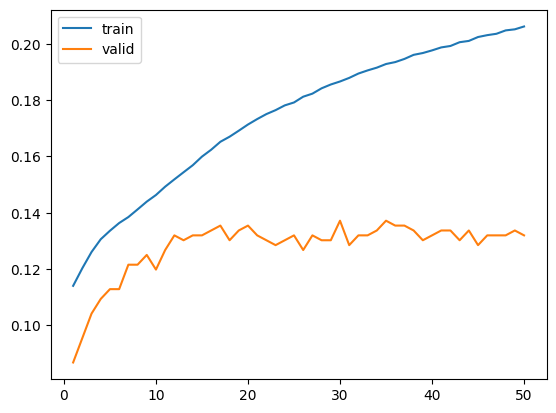

In [69]:
epoch_count = range(1, len(history1['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history1['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history1['val_accuracy'], label='valid')
plt.show()

> Modelo con embeddings freezados

In [96]:
model_embeddings = GloveEmbeddings()

print("preparing embedding matrix...")
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

special_tokens = ["<pad>", "<unk>", "<sos>", "<eos>"]
for t in special_tokens:
    if t not in word2idx_inputs:
        word2idx_inputs[t] = len(word2idx_inputs) + 1

nb_words = len(word2idx_inputs)
embedding_matrix = np.zeros((nb_words + 1, embed_dim))

for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue

    emb_vec = model_embeddings.get_words_embeddings([word])
    if emb_vec is not None and len(emb_vec) > 0:
        embedding_matrix[i] = emb_vec[0]
    else:
        words_not_found.append(word)
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embed_dim,))

# asignar tokens especiales explícitamente
embedding_matrix[word2idx_inputs["<pad>"]] = np.zeros((embed_dim,))
for tok in ["<unk>", "<sos>", "<eos>"]:
    embedding_matrix[word2idx_inputs[tok]] = np.random.normal(scale=0.6, size=(embed_dim,))

print(f"number of null word embeddings: {np.sum(np.sum(embedding_matrix, axis=1) == 0)}")
print(f"coverage: {(1 - np.sum(np.sum(embedding_matrix, axis=1) == 0)/embedding_matrix.shape[0])*100:.2f}%")


preparing embedding matrix...
number of null word embeddings: 140
coverage: 92.24%


✅ Modelo, optimizer y criterion inicializados correctamente
Epoch 01/50 | Train Loss: 4.877 | Train Acc: 0.046 | Val Loss: 4.376 | Val Acc: 0.047
Epoch 02/50 | Train Loss: 3.677 | Train Acc: 0.085 | Val Loss: 3.833 | Val Acc: 0.062
Epoch 03/50 | Train Loss: 3.240 | Train Acc: 0.100 | Val Loss: 3.517 | Val Acc: 0.078
Epoch 04/50 | Train Loss: 2.972 | Train Acc: 0.109 | Val Loss: 3.332 | Val Acc: 0.082
Epoch 05/50 | Train Loss: 2.787 | Train Acc: 0.115 | Val Loss: 3.193 | Val Acc: 0.094
Epoch 06/50 | Train Loss: 2.623 | Train Acc: 0.119 | Val Loss: 3.088 | Val Acc: 0.099
Epoch 07/50 | Train Loss: 2.484 | Train Acc: 0.124 | Val Loss: 3.022 | Val Acc: 0.104
Epoch 08/50 | Train Loss: 2.363 | Train Acc: 0.126 | Val Loss: 2.951 | Val Acc: 0.108
Epoch 09/50 | Train Loss: 2.257 | Train Acc: 0.130 | Val Loss: 2.917 | Val Acc: 0.102
Epoch 10/50 | Train Loss: 2.161 | Train Acc: 0.132 | Val Loss: 2.863 | Val Acc: 0.106
Epoch 11/50 | Train Loss: 2.069 | Train Acc: 0.134 | Val Loss: 2.817 | Val Acc: 

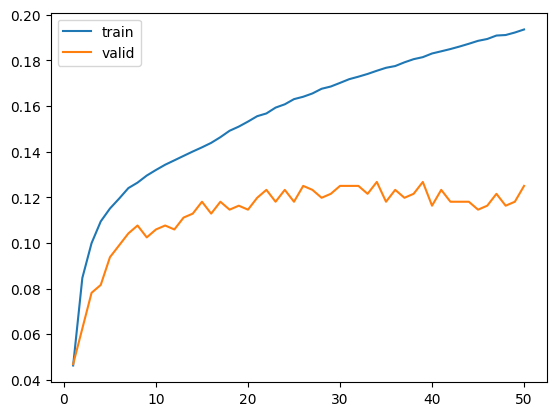

In [97]:
encoder = Encoder(VOCAB_SIZE, embedding_matrix, PAD_TOKEN, train_embeddings=False)
decoder = Decoder(VOCAB_SIZE, embedding_matrix, PAD_TOKEN,  train_embeddings=False)
model_freezed = Seq2Seq(encoder, decoder).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
optimizer = torch.optim.Adam(model_freezed.parameters(), lr=0.001)

print("✅ Modelo, optimizer y criterion inicializados correctamente")

history2 = train(
    model_freezed,
    train_loader,
    valid_loader,
    optimizer,
    criterion,
    epochs=50
)

epoch_count = range(1, len(history2['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history2['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history2['val_accuracy'], label='valid')
plt.show()

> #### Modelo con embeddings fastext

In [82]:
model_embeddings = FasttextEmbeddings()

print("preparing embedding matrix...")
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

special_tokens = ["<pad>", "<unk>", "<sos>", "<eos>"]
for t in special_tokens:
    if t not in word2idx_inputs:
        word2idx_inputs[t] = len(word2idx_inputs) + 1

nb_words = len(word2idx_inputs)
embedding_matrix = np.zeros((nb_words + 1, embed_dim))

for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue

    emb_vec = model_embeddings.get_words_embeddings([word])
    if emb_vec is not None and len(emb_vec) > 0:
        embedding_matrix[i] = emb_vec[0]
    else:
        words_not_found.append(word)
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embed_dim,))

# asignar tokens especiales explícitamente
embedding_matrix[word2idx_inputs["<pad>"]] = np.zeros((embed_dim,))
for tok in ["<unk>", "<sos>", "<eos>"]:
    embedding_matrix[word2idx_inputs[tok]] = np.random.normal(scale=0.6, size=(embed_dim,))

print(f"number of null word embeddings: {np.sum(np.sum(embedding_matrix, axis=1) == 0)}")
print(f"coverage: {(1 - np.sum(np.sum(embedding_matrix, axis=1) == 0)/embedding_matrix.shape[0])*100:.2f}%")


preparing embedding matrix...
number of null word embeddings: 102
coverage: 94.35%


✅ Modelo, optimizer y criterion inicializados correctamente
Epoch 01/50 | Train Loss: 4.686 | Train Acc: 0.058 | Val Loss: 4.070 | Val Acc: 0.062
Epoch 02/50 | Train Loss: 3.299 | Train Acc: 0.101 | Val Loss: 3.480 | Val Acc: 0.080
Epoch 03/50 | Train Loss: 2.818 | Train Acc: 0.117 | Val Loss: 3.180 | Val Acc: 0.095
Epoch 04/50 | Train Loss: 2.519 | Train Acc: 0.127 | Val Loss: 2.917 | Val Acc: 0.113
Epoch 05/50 | Train Loss: 2.299 | Train Acc: 0.133 | Val Loss: 2.790 | Val Acc: 0.113
Epoch 06/50 | Train Loss: 2.119 | Train Acc: 0.138 | Val Loss: 2.656 | Val Acc: 0.115
Epoch 07/50 | Train Loss: 1.966 | Train Acc: 0.141 | Val Loss: 2.628 | Val Acc: 0.118
Epoch 08/50 | Train Loss: 1.836 | Train Acc: 0.145 | Val Loss: 2.552 | Val Acc: 0.123
Epoch 09/50 | Train Loss: 1.712 | Train Acc: 0.148 | Val Loss: 2.492 | Val Acc: 0.132
Epoch 10/50 | Train Loss: 1.597 | Train Acc: 0.152 | Val Loss: 2.480 | Val Acc: 0.132
Epoch 11/50 | Train Loss: 1.498 | Train Acc: 0.156 | Val Loss: 2.449 | Val Acc: 

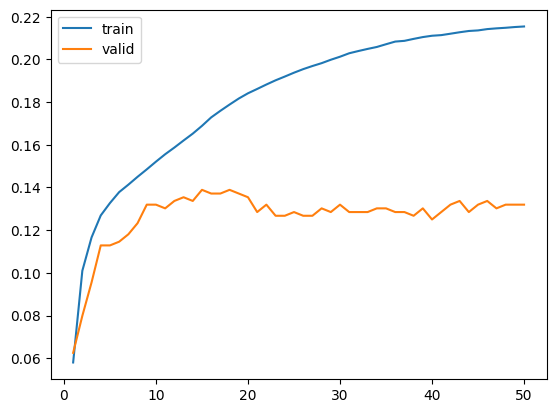

In [87]:
encoder = Encoder(VOCAB_SIZE, embedding_matrix, PAD_TOKEN, train_embeddings=True)
decoder = Decoder(VOCAB_SIZE, embedding_matrix, PAD_TOKEN,  train_embeddings=True)
model_ft_embeddings = Seq2Seq(encoder, decoder).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
optimizer = torch.optim.Adam(model_ft_embeddings.parameters(), lr=0.001)

print("✅ Modelo, optimizer y criterion inicializados correctamente")

history3 = train(
    model_ft_embeddings,
    train_loader,
    valid_loader,
    optimizer,
    criterion,
    epochs=50
)

epoch_count = range(1, len(history3['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history3['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history3['val_accuracy'], label='valid')
plt.show()

> #### Modelo con embeddings fastext freezado

In [98]:
model_embeddings = FasttextEmbeddings()

print("preparing embedding matrix...")
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

special_tokens = ["<pad>", "<unk>", "<sos>", "<eos>"]
for t in special_tokens:
    if t not in word2idx_inputs:
        word2idx_inputs[t] = len(word2idx_inputs) + 1

nb_words = len(word2idx_inputs)
embedding_matrix = np.zeros((nb_words + 1, embed_dim))

for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue

    emb_vec = model_embeddings.get_words_embeddings([word])
    if emb_vec is not None and len(emb_vec) > 0:
        embedding_matrix[i] = emb_vec[0]
    else:
        words_not_found.append(word)
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embed_dim,))

# asignar tokens especiales explícitamente
embedding_matrix[word2idx_inputs["<pad>"]] = np.zeros((embed_dim,))
for tok in ["<unk>", "<sos>", "<eos>"]:
    embedding_matrix[word2idx_inputs[tok]] = np.random.normal(scale=0.6, size=(embed_dim,))

print(f"number of null word embeddings: {np.sum(np.sum(embedding_matrix, axis=1) == 0)}")
print(f"coverage: {(1 - np.sum(np.sum(embedding_matrix, axis=1) == 0)/embedding_matrix.shape[0])*100:.2f}%")


preparing embedding matrix...
number of null word embeddings: 102
coverage: 94.35%


✅ Modelo, optimizer y criterion inicializados correctamente
Epoch 01/50 | Train Loss: 4.831 | Train Acc: 0.050 | Val Loss: 4.318 | Val Acc: 0.057
Epoch 02/50 | Train Loss: 3.626 | Train Acc: 0.087 | Val Loss: 3.843 | Val Acc: 0.068
Epoch 03/50 | Train Loss: 3.211 | Train Acc: 0.104 | Val Loss: 3.540 | Val Acc: 0.078
Epoch 04/50 | Train Loss: 2.960 | Train Acc: 0.110 | Val Loss: 3.386 | Val Acc: 0.082
Epoch 05/50 | Train Loss: 2.783 | Train Acc: 0.114 | Val Loss: 3.280 | Val Acc: 0.083
Epoch 06/50 | Train Loss: 2.636 | Train Acc: 0.118 | Val Loss: 3.184 | Val Acc: 0.095
Epoch 07/50 | Train Loss: 2.521 | Train Acc: 0.122 | Val Loss: 3.073 | Val Acc: 0.099
Epoch 08/50 | Train Loss: 2.408 | Train Acc: 0.125 | Val Loss: 2.991 | Val Acc: 0.101
Epoch 09/50 | Train Loss: 2.315 | Train Acc: 0.128 | Val Loss: 2.930 | Val Acc: 0.106
Epoch 10/50 | Train Loss: 2.226 | Train Acc: 0.131 | Val Loss: 2.844 | Val Acc: 0.111
Epoch 11/50 | Train Loss: 2.141 | Train Acc: 0.133 | Val Loss: 2.822 | Val Acc: 

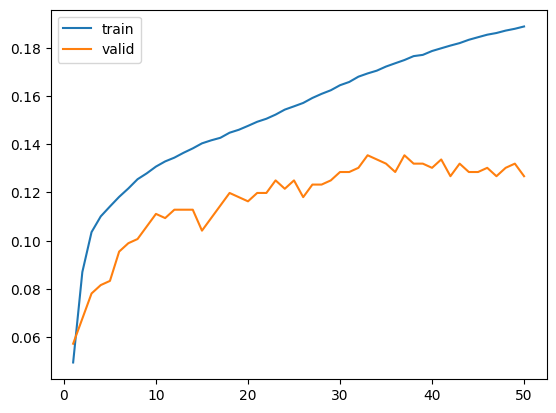

In [99]:
encoder = Encoder(VOCAB_SIZE, embedding_matrix, PAD_TOKEN, train_embeddings=False)
decoder = Decoder(VOCAB_SIZE, embedding_matrix, PAD_TOKEN,  train_embeddings=False)
model_ft_embeddings_freezed = Seq2Seq(encoder, decoder).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
optimizer = torch.optim.Adam(model_ft_embeddings_freezed.parameters(), lr=0.001)

print("✅ Modelo, optimizer y criterion inicializados correctamente")

history4 = train(
    model_ft_embeddings_freezed,
    train_loader,
    valid_loader,
    optimizer,
    criterion,
    epochs=50
)

epoch_count = range(1, len(history4['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history4['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history4['val_accuracy'], label='valid')
plt.show()

### **5 - Inferencia**

In [100]:
import torch
import numpy as np
from scipy.special import softmax

def infer(model, input_seq, word2idx_output, idx2word_output,
          max_output_len=20, device="cuda",
          beam_size=3, temperature=1.0, stochastic=False):
    """
    Inferencia con opción de greedy o beam search.

    Args:
        model: modelo Seq2Seq (encoder + decoder)
        input_seq: secuencia tokenizada de entrada (lista o tensor)
        word2idx_output: vocab del decoder (str → int)
        idx2word_output: vocab inverso (int → str)
        max_output_len: largo máximo de la secuencia generada
        beam_size: cantidad de beams (1 = greedy)
        temperature: suaviza distribución en modo estocástico
        stochastic: si True, elige tokens por muestreo en vez de argmax
    """
    model.eval()
    with torch.no_grad():
        # --- 1️⃣ Codificación ---
        input_tensor = torch.tensor([input_seq], dtype=torch.long).to(device)
        encoder_hidden, encoder_cell = model.encoder(input_tensor)

        sos_token = word2idx_output.get("<sos>", 1)
        eos_token = word2idx_output.get("<eos>", 2)

        # --- 2️⃣ Inicialización de beams ---
        beams = [{
            "tokens": [sos_token],
            "hidden": encoder_hidden,
            "cell": encoder_cell,
            "logprob": 0.0
        }]

        # --- 3️⃣ Decodificación autoregresiva ---
        for _ in range(max_output_len):
            new_beams = []
            for beam in beams:
                last_token = beam["tokens"][-1]
                if last_token == eos_token:
                    new_beams.append(beam)
                    continue

                decoder_input = torch.tensor([[last_token]], dtype=torch.long).to(device)
                output, (h, c) = model.decoder(decoder_input, (beam["hidden"], beam["cell"]))

                # logits → probabilidades
                probs = torch.softmax(output.squeeze(0) / temperature, dim=-1).cpu().numpy()

                if stochastic:
                    # muestreo aleatorio ponderado por softmax
                    top_indices = np.random.choice(len(probs), beam_size, p=probs / probs.sum())
                else:
                    # top-k determinístico
                    top_indices = probs.argsort()[-beam_size:][::-1]

                for idx in top_indices:
                    new_beams.append({
                        "tokens": beam["tokens"] + [idx],
                        "hidden": h,
                        "cell": c,
                        "logprob": beam["logprob"] + np.log(probs[idx] + 1e-10)
                    })

            # mantener los mejores beams según logprob promedio
            beams = sorted(new_beams, key=lambda b: b["logprob"] / len(b["tokens"]), reverse=True)[:beam_size]

        # --- 4️⃣ Seleccionar mejor secuencia ---
        best_beam = max(beams, key=lambda b: b["logprob"] / len(b["tokens"]))
        decoded_tokens = [
            tok for tok in best_beam["tokens"]
            if tok not in [sos_token, eos_token]
        ]

        # --- 5️⃣ Decodificar texto ---
        decoded_sentence = " ".join([idx2word_output.get(tok, "<unk>") for tok in decoded_tokens])

    return decoded_sentence, [b["tokens"] for b in beams]  # devuelve también todos los beams


In [101]:
def encode_sentence(sentence, tokenizer, max_len):
    # limpiar y convertir a índices usando el tokenizer
    seq = tokenizer.texts_to_sequences([sentence.lower().strip()])[0]

    # aplicar padding pre para que tenga longitud fija igual a la del entrenamiento
    if len(seq) < max_len:
        seq = [0] * (max_len - len(seq)) + seq
    else:
        seq = seq[-max_len:]

    return seq


In [102]:
def benchmark_questions(model, model_name):
  questions = [
      "Do you read?",
      "Do you have any pet?",
      "Where are you from?"
  ]
  for question in questions:
      input_seq = encode_sentence(question, input_tokenizer, max_input_len)

      generated_answer, beams = infer(
          model,
          input_seq=input_seq,
          word2idx_output=word2idx_outputs,
          idx2word_output=idx2word_outputs,
          beam_size=5,
          temperature=0.8,
          stochastic=True,   # False para beam search determinístico
          device=device
      )

      print(f"Q: {question}")
      print(f"A: {generated_answer}")


> #### Benchmark questions

In [103]:
models = {
    "GloveEmbeddings": model,
    "GloveEmbeddings_freezed": model_freezed,
    "FasttextEmbeddings": model_ft_embeddings,
    "FasttextEmbeddings_freezed": model_ft_embeddings_freezed
}


for model_name, model in models.items():
    print(f"\nBenchmarking {model_name}...\n")
    benchmark_questions(model, model_name)
    print("--"*40)


Benchmarking GloveEmbeddings...

Q: Do you read?
A: kill kill kill kill kill you anytime me red red red red red red and red wow red pls red
Q: Do you have any pet?
A: and and question and you not a girl girl i am a girl you girl that means means means alone
Q: Where are you from?
A: m already tell u r yourself or girl you too have you a boyfriend car what kind of work at
--------------------------------------------------------------------------------

Benchmarking GloveEmbeddings_freezed...

Q: Do you read?
A: hoo or night night night night okay lover same sorry sorry single them either sorry you have do for job
Q: Do you have any pet?
A: only is a 36 year old are you married teacher job married i love to read beach i love read
Q: Where are you from?
A: haryana and you also good book good night years health to go to do you do for a living do
--------------------------------------------------------------------------------

Benchmarking FasttextEmbeddings...

Q: Do you read?
A: kill kil

### **6 - Conclusión**


Se realizaron experimentos con una arquitectura encoder–decoder seq2seq durante 50 epochs, utilizando distintos esquemas de word embeddings.

Con GloVe (50d), la mejor configuración fue con embeddings entrenables, ya que al mantenerlos freezados el modelo no logró adaptarse al dominio. Aun así, las respuestas resultaron poco coherentes y repetitivas, lo que sugiere que la representación de baja dimensionalidad fue insuficiente.

Al usar FastText (300d), se observó una mejora en la coherencia y fluidez, aunque los resultados globales siguieron siendo limitados. En general, sería recomendable seguir explorando modelos más complejos, mayor tiempo de entrenamiento o datasets más amplios y diversos. Además, el caso en el que se freezaron los embeddings fue mejor que el caso en el que se configuraron como entrenables.

*Nota: las respuestas de glove embeddings y fast text sin freezar a la pregunta "do you read" dan un poco de miedo*